<a href="https://colab.research.google.com/github/choarauc/form/blob/main/Intrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- This is a small sample of data (both in terms of observations and available variables) that is actually used for training our models in Intrum. All the IDs are replaced, and all datapoints have a slight noise added to them to avoid any chance of identification. Data is stored as a small SQLite database stored in attached `dataset.db` file. There are two tables - `dataset` and `metadata`. The data sample spans 1 year and 30k observations.



<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>INTRUM</h1></center>
<center><h2>predict the probability of the payment within 90 days! </h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


 - We will work with the **Intrum** database. This database initially contains ;

       a8404 RatioOfCustomersAtAddressWithSuccessfullyClose
       ap090 TargetAmount90Days
       c0001 Variable OriginalCapitalOfCaseInvoices
       c0015 Variable AmountOfCase
       c0019 Variable AgeOfDebt
       c0031 Variable NumberOfTelephonesCI
       c0039 Variable de code d'industrie
       c0044 Variable NomClient
       c9008 Variable CustomerAge
       ct090 Target90Days target
       b0007 AmountOfCustomerPaymentsOnAllCasesBlevel
       d0009 Variable AmountOfCustomerOpenCases 
       d0012 Variable LastOriginalClosingCodeOfCustomer
       d0027 NumberOfCustomerIncomingCallDatesTee variable
       d1205 Variable NumberOfSuccessfullyClosedCasesInLast24Months
       d2112 Variable NumberOfCustomerPaymentsInLast12Months
       d0031 NumberOfUnsuccessfullyClosedCustomerCasesLast3


> The intended target for prediction is `ct090`, 
> 
> `case_id` is the unique identifier, 
> 
>  `keydate` is the point in time when some event has happened in the lifecycle of a case, and also a date relative to which all of the backward looking variables and forward looking targets are calculated.
> 
>In this case, it's a general purpose propensity to pay model, which means that it is a freshly registered case, where all the relevant data has been gathered and verified.
> 
> `keydate` is set a few days after registration, and target `ct090` is checking for outcome in 90 days (`ap090` is a similar regression target), while all the rest of the data is only looking backwards!
   



> La estructura es la siguiente : 
>> I - [Procesamiento de conjuntos de datos](#preparation)
>>> A - [Data Cleaning & Preprocessing](#affichage)
>>>
>>>
>>> B - [Visualización de datos](#generateurs)
>>
>>
>> II - [1ra Iteración](#classif)
>>> A - [ML - clasificación  ](#affichage2)
>>>
>>>
>>> B - [modelado final](#generateurs2)
>>
>>
>> III - [Interpretación](#test)

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving dataset.csv to dataset.csv


# Librería

In [ ]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import  push_notebook,output_notebook, show
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
import plotly.express as px
import statsmodels.api
output_notebook()

import statsmodels.api
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from imblearn.metrics import classification_report_imbalanced


from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@title
df = pd.read_csv('dataset.csv', delimiter = ',', parse_dates=['keydate'],dayfirst=True)
df.info()

print("El dataframe contiene", df.shape[0], 'lineas y', df.shape[1], 'columnas.')
print(df.duplicated().sum()) # pas de doublons

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   case_id  30000 non-null  int64         
 1   keydate  30000 non-null  datetime64[ns]
 2   ct090    30000 non-null  float64       
 3   ap090    30000 non-null  float64       
 4   c0001    29975 non-null  float64       
 5   c0039    30000 non-null  object        
 6   c0044    30000 non-null  int64         
 7   d0031    17371 non-null  float64       
 8   b0007    13074 non-null  float64       
 9   d0009    30000 non-null  float64       
 10  c0031    30000 non-null  float64       
 11  a8404    19599 non-null  float64       
 12  c0019    30000 non-null  float64       
 13  d0027    30000 non-null  float64       
 14  c9008    27016 non-null  float64       
 15  d2112    13048 non-null  float64       
 16  d0012    30000 non-null  int64         
 17  d1205    8762 non-null   float6

# Procesamiento del dataset 

## Data Cleaning & Preprocessing 

In [ ]:
dict = {
    'case_id' : 'case_id',
    'keydate  ' : 'keydate',
    'ct090' : 'Target90Days', #Target, case
    'ap090' : 'TargetAmount90Days', #Target, case
    'c0001' : 'OriginalCapitalOfCaseInvoices', #Variable, case 
    'c0039' : 'IndustryCode', #Variable, case
    'c0044' : 'ClientName', #Variable, case
    'd0031' : 'NumberOfUnsuccessfullyClosedCustomerCasesLast36Months', # 
    'b0007' : 'AmountOfCustomerPaymentsOnAllCasesBlevel' , #Variable, debtor 
    'd0009' : 'AmountOfCustomerOpenCases', #Variable, debtor_oc
    'c0031' : 'NumberOfTelephonesCI', #Variable, case
    'a8404' : 'RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months', #Variable, address 
    'c0019' : 'AgeOfDebt', #Variable, case
    'd0027' : 'NumberOfCustomerIncomingCallDatesTee', #Variable, debtor_oc
    'c9008' : 'CustomerAge', #Variable, case
    'd2112' : 'NumberOfCustomerPaymentsInLast12Months', #Variable, debtor_oc
    'd0012' : 'LastOriginalClosingCodeOfCustomer', #Variable, debtor_oc
    'd1205' : 'NumberOfSuccessfullyClosedCasesInLast24Months', #Variable, debtor_oc
    'c0015' : 'AmountOfCase' #Variable, case
}

df = df.rename(dict, axis =1)
df.head(5)

,case_id,keydate,Target90Days,TargetAmount90Days,OriginalCapitalOfCaseInvoices,IndustryCode,ClientName,NumberOfUnsuccessfullyClosedCustomerCasesLast36Months,AmountOfCustomerPaymentsOnAllCasesBlevel,AmountOfCustomerOpenCases,NumberOfTelephonesCI,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months,AgeOfDebt,NumberOfCustomerIncomingCallDatesTee,CustomerAge,NumberOfCustomerPaymentsInLast12Months,LastOriginalClosingCodeOfCustomer,NumberOfSuccessfullyClosedCasesInLast24Months,AmountOfCase
0,1,2017-08-12,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
1,2,2017-02-03,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
2,3,2017-02-17,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.0,748.0,0.0,48.0,NaN,3,NaN,56.84
3,4,2017-09-18,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.0,8.0,0.0,27.0,NaN,4,NaN,463.15
4,5,2017-07-22,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09


In [ ]:
#@title
df.describe()

,case_id,Target90Days,TargetAmount90Days,OriginalCapitalOfCaseInvoices,ClientName,NumberOfUnsuccessfullyClosedCustomerCasesLast36Months,AmountOfCustomerPaymentsOnAllCasesBlevel,AmountOfCustomerOpenCases,NumberOfTelephonesCI,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months,AgeOfDebt,NumberOfCustomerIncomingCallDatesTee,CustomerAge,NumberOfCustomerPaymentsInLast12Months,LastOriginalClosingCodeOfCustomer,NumberOfSuccessfullyClosedCasesInLast24Months,AmountOfCase
count,30000.000000,30000.000000,30000.000000,29975.000000,30000.000000,17371.000000,13074.000000,30000.000000,30000.000000,19599.000000,30000.000000,30000.000000,27016.000000,13048.000000,30000.000000,8762.000000,30000.000000
mean,15000.500000,0.168733,49.215836,538.590694,22.106433,1.634391,423.156043,555.063823,3.092900,0.283395,104.948833,0.473067,42.339466,0.935622,5.273033,0.897170,605.535361
std,8660.398374,0.374522,240.063401,1248.533877,24.037819,1.318419,902.166491,1939.588574,2.151021,0.312366,196.864753,1.397094,13.215883,1.755761,7.241761,0.814515,1223.783876
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-319.010000,0.000000,0.000000,3.000000,0.000000,6.000000,0.000000,1.000000,0.000000,9.750000
25%,7500.750000,0.000000,0.000000,145.100000,6.000000,1.000000,76.000000,0.000000,2.000000,0.000000,10.000000,0.000000,32.000000,0.000000,1.000000,0.000000,185.410000
50%,15000.500000,0.000000,0.000000,298.720000,12.000000,1.000000,202.715000,0.000000,3.000000,0.210000,77.000000,0.000000,41.000000,0.000000,4.000000,1.000000,355.650000
75%,22500.250000,0.000000,0.000000,638.645000,30.000000,2.000000,500.677500,481.322500,4.000000,0.450000,126.000000,0.000000,51.000000,1.000000,7.000000,1.000000,725.480000
max,30000.000000,1.000000,25000.000000,84561.840000,181.000000,15.000000,53982.610000,110158.640000,35.000000,1.000000,6193.000000,40.000000,117.000000,24.000000,102.000000,15.000000,84561.840000


-   basée sur des préfixes qui définissent les niveaux d'agrégation - `cXXXX` en regardant les données de ce cas uniquement, `dXXXX` en regardant les autres cas du même débiteur, `bXXXX` en regardant tous les cas du débiteur, `aXXXX` regardant tous les cas sur la même adresse. 

> Variables cuantitativas en gráfico de barras

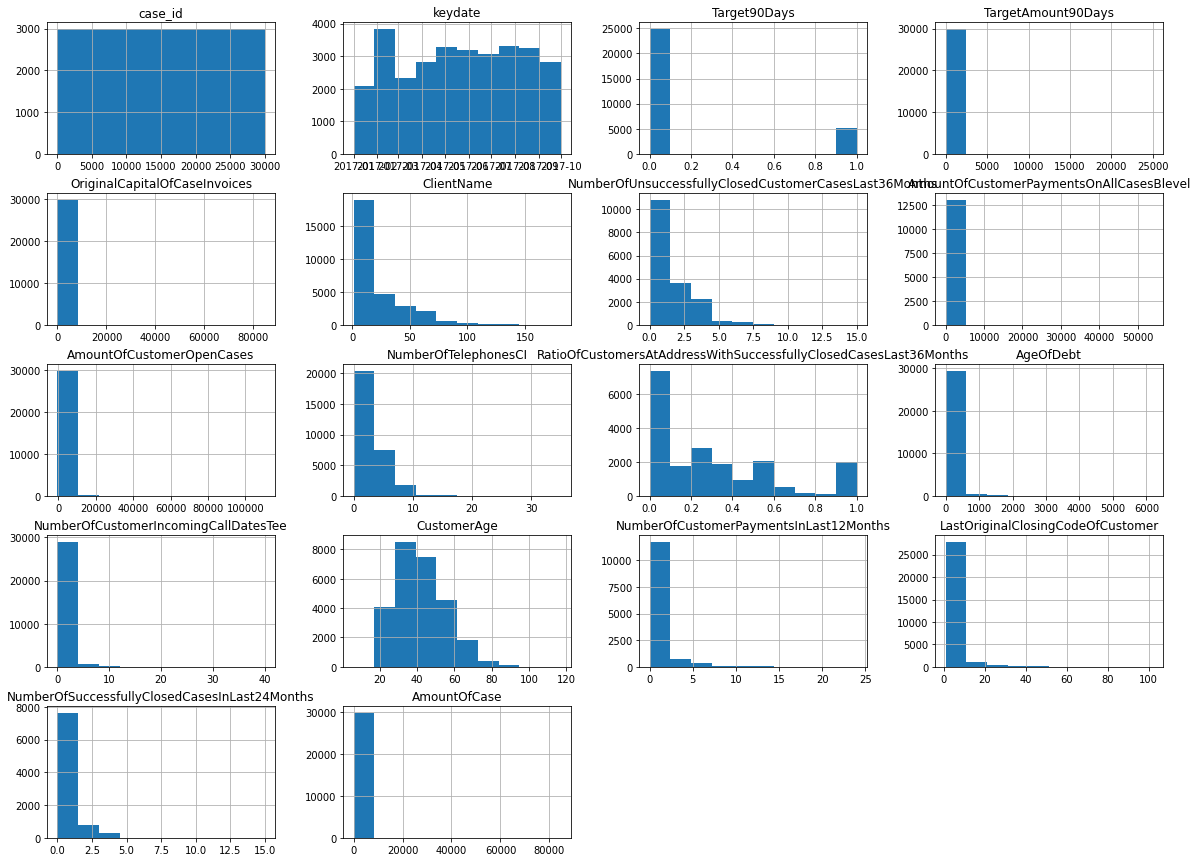

In [ ]:
#@title
# Variables cuantitativas en gráfico de barras
df.hist(bins=10,figsize=(20,15));

* **Target**

In [ ]:
# analyse de ma target

df['Target90Days'] = df['Target90Days'].astype(int)
print(df.Target90Days.unique())

#@title
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

lst = df.Target90Days

x = 1

print('{} has occurred {} times'.format(x, countX(lst, x)) )
print(countX(lst, x) * x)

[0 1]
1 has occurred 5062 times
5062


* **Data Cleaning**

In [ ]:
#@title
def valeur_manquante(df):
    flag=0
    for col in df.columns:
            if df[col].isna().sum() > 0:
                flag=1
                print(f'"{col}": {df[col].isna().sum()} valeur(s) manquante(s)')
    if flag==0:
        print("Le dataset ne contient plus de valeurs manquantes.")

valeur_manquante(df)

"OriginalCapitalOfCaseInvoices": 25 valeur(s) manquante(s)
"NumberOfUnsuccessfullyClosedCustomerCasesLast36Months": 12629 valeur(s) manquante(s)
"AmountOfCustomerPaymentsOnAllCasesBlevel": 16926 valeur(s) manquante(s)
"RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months": 10401 valeur(s) manquante(s)
"CustomerAge": 2984 valeur(s) manquante(s)
"NumberOfCustomerPaymentsInLast12Months": 16952 valeur(s) manquante(s)
"NumberOfSuccessfullyClosedCasesInLast24Months": 21238 valeur(s) manquante(s)


- ***IndustryCode***
- ***Original Capital Of Case Invoices***
- ***Customer Age & Age of Debt***

In [ ]:
df['AgeOfDebt'] = df['AgeOfDebt'].astype(int)
df['NumberOfTelephonesCI'] = df['NumberOfTelephonesCI'].astype(int)
df['NumberOfCustomerIncomingCallDatesTee'] = df['NumberOfCustomerIncomingCallDatesTee'].astype(int)

df['IndustryCode'] = df['IndustryCode'].astype('category').cat.codes  # puede tener sentido en una gran base de datos para la predicción de fallas

df = df.dropna(subset = ['OriginalCapitalOfCaseInvoices'], axis=0) # 25 nan, drop is null 
df['CustomerAge'] = df['CustomerAge'].fillna(df['CustomerAge'].mode()[0]) # reemplazar por el modo no debería tener impacto en el puntaje 
df = df[df['AgeOfDebt'] < 2000 ] # eliminar filas > 2000 días = valores atípicos que podrían sesgar nuestras puntuaciones

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29932 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column                                                            Non-Null Count  Dtype         
---  ------                                                            --------------  -----         
 0   case_id                                                           29932 non-null  int64         
 1   keydate                                                           29932 non-null  datetime64[ns]
 2   Target90Days                                                      29932 non-null  int64         
 3   TargetAmount90Days                                                29932 non-null  float64       
 4   OriginalCapitalOfCaseInvoices                                     29932 non-null  float64       
 5   IndustryCode                                                      29932 non-null  int8          
 6   ClientName                                                        2993

***Number Of Unsuccessfully Closed Customer Cases Last 36 Months***

* interprétation des valeurs manquantes : 
> si la variable est liée à une fenêtre temporelle, par exemple `d2112 NumberOfCustomerPaymentsInLast12Months`, 
> 
> la valeur `NA` implique qu'il n'y a jamais eu de valeurs, 
> 
> tandis que `0` signifierait qu'il n'y a eu aucune valeur dans période de délimitation (dans ce cas 12 mois). 
> 
> '0' et 'NA' ont une interprétation **différente**.


In [ ]:
#@title
# 12616 nan

df['NumberOfUnsuccessfullyClosedCustomerCasesLast36Months'] = df['NumberOfUnsuccessfullyClosedCustomerCasesLast36Months'].replace(np.nan, 0)
df.NumberOfUnsuccessfullyClosedCustomerCasesLast36Months.unique()


array([ 2.,  0.,  1.,  3.,  6.,  5.,  7.,  4.,  8., 10.,  9., 11., 14.,
       13., 15., 12.])

***Amount Of Customer Payments On All Cases B level***

In [ ]:
#@title
# 16910 nan

df.AmountOfCustomerPaymentsOnAllCasesBlevel.unique()

df['AmountOfCustomerPaymentsOnAllCasesBlevel'] = df['AmountOfCustomerPaymentsOnAllCasesBlevel'].replace(np.nan, 0)

***Ratio Of Customers At Address With Successfully Closed Cases Last 36Months***

In [ ]:
#@title
# 10393 nan

df.RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months.unique()


array([ nan, 0.  , 1.  , 0.36, 0.25, 0.33, 0.29, 0.37, 0.28, 0.09, 0.4 ,
       0.13, 0.5 , 0.18, 0.45, 0.17, 0.3 , 0.47, 0.2 , 0.15, 0.21, 0.07,
       0.08, 0.52, 0.41, 0.6 , 0.75, 0.22, 0.38, 0.12, 0.11, 0.19, 0.16,
       0.44, 0.66, 0.23, 0.06, 0.46, 0.8 , 0.26, 0.57, 0.03, 0.43, 0.27,
       0.14, 0.31, 0.1 , 0.64, 0.42, 0.7 , 0.34, 0.71, 0.58, 0.35, 0.54,
       0.55, 0.83, 0.39, 0.56, 0.49, 0.04, 0.05, 0.24, 0.63, 0.62, 0.53,
       0.67, 0.61, 0.32, 0.65, 0.48, 0.69, 0.72, 0.85, 0.77, 0.76, 0.51,
       0.02, 0.59, 0.87, 0.68, 0.88, 0.78, 0.73, 0.81])

***Number Of Customer Payments In Last 12Months***

In [ ]:
#@title
# 16936 nan

df.NumberOfCustomerPaymentsInLast12Months.unique()

df['NumberOfCustomerPaymentsInLast12Months'] = df['NumberOfCustomerPaymentsInLast12Months'].replace(np.nan, 0)

***Number Of Successfully Closed Cases In Last 24 Months***

In [ ]:
#@title
# 21218 nan

df.NumberOfSuccessfullyClosedCasesInLast24Months.unique()

array([nan,  1.,  0.,  2.,  3.,  4.,  5.,  8., 11.,  7.,  6., 13., 15.])

## Data Visualisation

In [ ]:
# Calcul des corrélations de Pearson sur les variables quantitatives
corr = df.corr()

# Affichage de la heatmap de ces corrélations
corr.style.background_gradient(cmap='Reds')

,case_id,Target90Days,TargetAmount90Days,OriginalCapitalOfCaseInvoices,IndustryCode,ClientName,NumberOfUnsuccessfullyClosedCustomerCasesLast36Months,AmountOfCustomerPaymentsOnAllCasesBlevel,AmountOfCustomerOpenCases,NumberOfTelephonesCI,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months,AgeOfDebt,NumberOfCustomerIncomingCallDatesTee,CustomerAge,NumberOfCustomerPaymentsInLast12Months,LastOriginalClosingCodeOfCustomer,NumberOfSuccessfullyClosedCasesInLast24Months,AmountOfCase,NumberOfUnsuccessfullyClosedCustomerCasesLast36Months,AmountOfCustomerPaymentsOnAllCasesBlevel,NumberOfCustomerPaymentsInLast12Months
case_id,1.000000,-0.003822,-0.001785,-0.001834,0.003147,0.012564,0.006916,-0.010089,0.006208,0.004343,-0.006132,0.001337,0.002666,0.003300,0.009187,0.018333,0.011761,-0.002248,0.002479,-0.003816,0.008324
Target90Days,-0.003822,1.000000,0.454981,-0.031666,-0.098535,-0.007864,-0.091394,0.021060,-0.051461,-0.085011,0.080477,0.024598,0.064768,0.043934,0.032738,0.038491,0.052054,-0.030036,-0.139486,0.071863,0.085676
TargetAmount90Days,-0.001785,0.454981,1.000000,0.178123,-0.054635,0.001953,-0.032645,0.045214,-0.012141,-0.042489,0.042254,0.011710,0.024039,0.026201,0.036354,0.018637,0.024990,0.189968,-0.063527,0.063977,0.059288
OriginalCapitalOfCaseInvoices,-0.001834,-0.031666,0.178123,1.000000,-0.163689,0.160152,0.013388,0.049563,0.072639,0.024220,0.005935,0.137680,-0.001509,-0.011059,0.004407,0.000723,0.004901,0.936868,0.024042,0.030555,0.001665
IndustryCode,0.003147,-0.098535,-0.054635,-0.163689,1.000000,-0.128884,0.043650,0.011196,0.009015,0.068798,-0.024728,-0.164296,0.016911,0.021626,-0.006738,0.006590,-0.029855,-0.171586,0.058244,0.000662,-0.010551
ClientName,0.012564,-0.007864,0.001953,0.160152,-0.128884,1.000000,-0.011622,-0.010489,0.007142,-0.005134,0.012561,0.132040,0.007528,-0.064174,0.013068,0.004339,0.008766,0.134920,-0.004912,-0.012501,0.001191
NumberOfUnsuccessfullyClosedCustomerCasesLast36Months,0.006916,-0.091394,-0.032645,0.013388,0.043650,-0.011622,1.000000,-0.011612,0.130877,0.411154,-0.061152,-0.021950,0.084930,0.008482,-0.016120,0.040357,-0.017165,0.017166,1.000000,0.041894,0.041425
AmountOfCustomerPaymentsOnAllCasesBlevel,-0.010089,0.021060,0.045214,0.049563,0.011196,-0.010489,-0.011612,1.000000,0.081726,0.059241,0.054399,0.017833,0.159578,0.068427,0.191491,0.048018,0.162478,0.058658,-0.006251,1.000000,0.191602
AmountOfCustomerOpenCases,0.006208,-0.051461,-0.012141,0.072639,0.009015,0.007142,0.130877,0.081726,1.000000,0.170135,-0.009219,-0.013972,0.052982,0.045030,0.106701,0.014733,-0.020135,0.078220,0.081492,0.046263,0.060501
NumberOfTelephonesCI,0.004343,-0.085011,-0.042489,0.024220,0.068798,-0.005134,0.411154,0.059241,0.170135,1.000000,-0.061460,-0.053748,0.156082,0.069567,0.018873,0.022073,-0.030447,0.033473,0.451956,0.083638,0.060384


### Acreedores más grandes

In [ ]:
fig = px.treemap(df, path=['ClientName'], values='AmountOfCase', color='ClientName')
fig.show()

print(df['ClientName'].value_counts(normalize=True))

6      0.104437
12     0.102365
2      0.091474
10     0.090772
11     0.037051
         ...   
167    0.000033
134    0.000033
156    0.000033
121    0.000033
181    0.000033
Name: ClientName, Length: 181, dtype: float64


> Dada la importancia de ciertos acreedores, podría ser apropiado desarrollar modelos individuales.
>
> Podría ser diferente el puntaje en una hipoteca que en una factura de teléfono?

In [ ]:
import statsmodels.api  #Méthode ANOVA 

result = statsmodels.formula.api.ols('Target90Days ~ NumberOfTelephonesCI', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)
table

,df,sum_sq,mean_sq,F,PR(>F)
NumberOfTelephonesCI,1.0,30.371526,30.371526,217.872783,3.920400e-49
Residual,29930.0,4172.250250,0.139400,NaN,NaN


In [ ]:
fig = px.density_heatmap(df, x="Target90Days", y="NumberOfTelephonesCI")
fig.show()

## Feature  Engineering

>**Normalmente este es el paso más importante.**
>
>Pero me faltan conocimientos de negocio para el sector de la cobranza..

> * para simplificar el ejercicio, me permito borrar las columnas con +40% de Nan's
> 
> * Esto afectará mi búsqueda de F1score con seguridad.
> 
> No obstente, tengo problemas con el simplo `metadata` para interpretar estas columnas para la gestión de valores faltantes.

In [ ]:
#do not run

to_drop = ['keydate', 
         'RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months', 
         'NumberOfSuccessfullyClosedCasesInLast24Months']

df.drop(to_drop, axis = 1, inplace = True)

In [ ]:
to_drop = ['keydate', 
         'RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months', 
         'NumberOfSuccessfullyClosedCasesInLast24Months', 'TargetAmount90Days']

df.drop(to_drop, axis = 1, inplace = True)

In [ ]:
#df['TargetAmount90Days'] = df['TargetAmount90Days'] .astype(float)
df['case_id'] = df['case_id'] .astype(float)
df['Target90Days'] = df['Target90Days'] .astype(float)
df['ClientName'] = df['ClientName'] .astype(float)
df['NumberOfTelephonesCI'] = df['NumberOfTelephonesCI'] .astype(float)
df['AgeOfDebt'] = df['AgeOfDebt'] .astype(float)
df['NumberOfCustomerIncomingCallDatesTee'] = df['NumberOfCustomerIncomingCallDatesTee'] .astype(float)
df['LastOriginalClosingCodeOfCustomer'] = df['LastOriginalClosingCodeOfCustomer'] .astype(float)

# 1ra Iteración 


## Clasificacion

In [ ]:
df.info()

In [ ]:
# Création des dataframes de cible et de données
target = df[['Target90Days']]
data=df.drop(['Target90Days'],axis=1)

# Création des dataframes d'entraînement et de test 
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_test = y_test.to_numpy().ravel()
y_train = y_train.to_numpy().ravel()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23945, 14)
(5987, 14)
(23945,)
(5987,)


In [ ]:
# Train
df_y_train=pd.DataFrame(y_train, columns=['Target90Days'])
print("% coincidencias por resultado en la muestra de entrenamiento")
display(df_y_train.Target90Days.value_counts(normalize=True).to_frame())

# Test
df_y_test=pd.DataFrame(y_test, columns=['Target90Days'])
print("% de coincidencias por resultado en la muestra de test")
display(df_y_test.Target90Days.value_counts(normalize=True).to_frame())

% coincidencias por resultado en la muestra de entrenamiento


,Target90Days
0.0,0.829985
1.0,0.170015


% de coincidencias por resultado en la muestra de test


,Target90Days
0.0,0.83531
1.0,0.16469


### SVM

Accuracy SVM:  0.8356438951060632


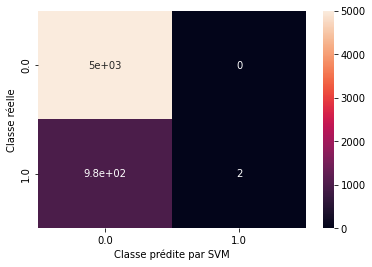

In [ ]:
# Modèle SVM avec les paramètres par défaut
svm = svm.SVC()
svm.fit(X_train, y_train)

# Matrice de confusion et scores
y_pred_svm = svm.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred_svm, rownames = ['Classe réelle'], colnames = ['Classe prédite par SVM'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy SVM: ',metrics.accuracy_score(y_test, y_pred_svm));

In [ ]:
# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_svm))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.84      1.00      0.00      0.91      0.05      0.00      5001
        1.0       1.00      0.00      1.00      0.00      0.05      0.00       986

avg / total       0.86      0.84      0.17      0.76      0.05      0.00      5987



### Random Forest

Accuracy RandomForest:  0.8328044095540338


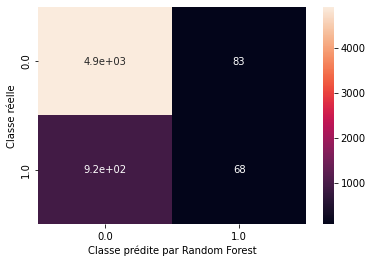

In [ ]:
# Modèle Random Forest avec les paramètres par défaut
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Matrice de confusion et scores
y_pred_rf = rf.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred_rf, rownames = ['Classe réelle'], colnames = ['Classe prédite par Random Forest'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy RandomForest: ',metrics.accuracy_score(y_test, y_pred_rf));

In [ ]:
# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.84      0.98      0.07      0.91      0.26      0.07      5001
        1.0       0.45      0.07      0.98      0.12      0.26      0.06       986

avg / total       0.78      0.83      0.22      0.78      0.26      0.07      5987



### KNN

Accuracy KNN:  0.8124269250041757


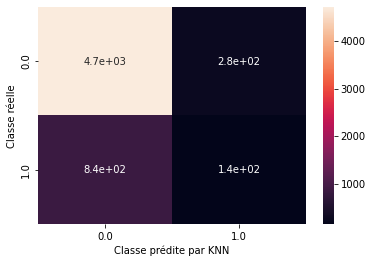

In [ ]:
# Modèle KNN avec les paramètres par défaut
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Matrice de confusion et scores
y_pred_knn = knn.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred_knn, rownames = ['Classe réelle'], colnames = ['Classe prédite par KNN'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy KNN: ',metrics.accuracy_score(y_test, y_pred_knn));

In [ ]:
# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_knn))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.85      0.94      0.14      0.89      0.37      0.15      5001
        1.0       0.34      0.14      0.94      0.20      0.37      0.13       986

avg / total       0.76      0.81      0.28      0.78      0.37      0.14      5987



### Bagging

In [ ]:
bc = BaggingClassifier(n_estimators = 1000, oob_score = True)
bc.fit(X_train, y_train)

# Erreur Out Of Bag
bc.oob_score_

0.8254332846105659

In [ ]:
# Score
print('Accuracy Bagging',bc.score(X_test, y_test))

Accuracy Bagging 0.8297978954401203


### XGBoost

Accuracy XGBoost:  0.835309837982295


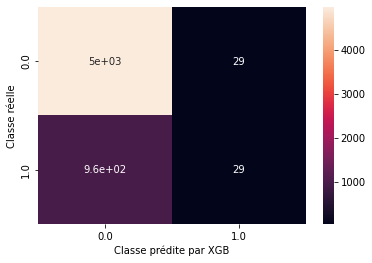

In [ ]:
boost = XGBClassifier()
boost.fit(X_train, y_train)

# Matrice de confusion et scores
y_pred_boost = boost.predict(X_test)
confusion_matrix = pd.crosstab(y_test,y_pred_boost, rownames = ['Classe réelle'], colnames = ['Classe prédite par XGB'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy XGBoost: ',metrics.accuracy_score(y_test, y_pred_boost));

### Reduction de dimension - PCA

In [ ]:
clf=KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors= 55, weights= 'distance')

pca = PCA(n_components = 0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
clf.fit(X_train_pca, y_train)
print('Accuracy With PCA', clf.score(X_test_pca, y_test))

Accuracy With PCA 0.8344746951728745


In [ ]:
print(pca.n_components_)

11


### Undersampling

In [ ]:
#Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)
#print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

#Centroids
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)
#print('Classes échantillon CC :', dict(pd.Series(y_cc).value_counts()))

In [ ]:
svm = SVC(gamma='scale')
svm.fit(X_ru, y_ru)

y_pred = svm.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

col_0   0.0   1.0
row_0            
0.0    3007  1994
1.0     330   656
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.90      0.60      0.67      0.72      0.63      0.40      5001
        1.0       0.25      0.67      0.60      0.36      0.63      0.40       986

avg / total       0.79      0.61      0.65      0.66      0.63      0.40      5987



In [ ]:
svm = SVC(gamma='scale')
svm.fit(X_cc, y_cc)

y_pred = svm.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

col_0   0.0   1.0
row_0            
0.0    1937  3064
1.0     255   731
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.88      0.39      0.74      0.54      0.54      0.28      5001
        1.0       0.19      0.74      0.39      0.31      0.54      0.30       986

avg / total       0.77      0.45      0.68      0.50      0.54      0.28      5987



### BalancedRandomForestClassifier

In [ ]:
bclf = BalancedRandomForestClassifier()
bclf.fit(X_train, y_train) 
y_pred = bclf.predict(X_test)
pd.crosstab(y_test, y_pred)

print('Accuracy With BalancedRandomForestClassifier', bclf.score(X_test, y_test))

Accuracy With BalancedRandomForestClassifier 0.6697845331551695


### Recap

In [ ]:
print('Accuracy SVM: ',metrics.accuracy_score(y_test, y_pred_svm));
print('Accuracy RandomForest: ',metrics.accuracy_score(y_test, y_pred_rf));
print('Accuracy KNN: ',metrics.accuracy_score(y_test, y_pred_knn));
print('Accuracy Bagging',bc.score(X_test, y_test))
print('Accuracy XGBoost: ',metrics.accuracy_score(y_test, y_pred_boost));
print('Accuracy With PCA', clf.score(X_test_pca, y_test))
print('Accuracy With BalancedRandomForestClassifier', bclf.score(X_test, y_test))


Accuracy SVM:  0.8356438951060632
Accuracy RandomForest:  0.8328044095540338
Accuracy KNN:  0.8124269250041757
Accuracy Bagging 0.8297978954401203
Accuracy XGBoost:  0.835309837982295
Accuracy With PCA 0.8344746951728745
Accuracy With BalancedRandomForestClassifier 0.6697845331551695


# Modelado Final


> Dadas las altas puntuaciones.
> 
> Debido a mi falta de conocimiento comercial en esta etapa, pero también a mis atajos en feature engineering ;
>> 
>> Tomare la accuracy mas baja para las interpretaciones finales...


### Modelo con peor desempeno

* DO NOT RUN! demasiado recurso de TPU

In [ ]:
#@title
# Modèle SVM
svm = svm.SVC()
parametres_svm = {'C':[0.1,1,2,5], 
                  'kernel':['rbf','linear', 'poly'], 
                  'gamma':[0.001, 0.1,0.2, 0.5]}

grid_svm = GridSearchCV(estimator = svm, param_grid = parametres_svm)

# Modèle KNN
knn = KNeighborsClassifier()
parametres_knn = {'n_neighbors' : [k for k in range(10,60,5)],
                  'weights' : ['uniform', 'distance'],
                 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                 'metric' : ['minkowski', 'manhattan', 'chebyshev', 'euclidean']}

grid_knn = GridSearchCV(estimator = knn, param_grid = parametres_knn)

# Modèle RF
rf = RandomForestClassifier()
parametres_rf = {'max_features': ["sqrt", "log2"], 
                 'min_samples_split': range(20, 50, 2)}

grid_rf = GridSearchCV(estimator=rf, param_grid = parametres_rf, cv=4)

# Validation croisée
cv = KFold(n_splits=3, random_state=22 , shuffle = True)

for clf, label in zip([grid_svm, grid_knn, grid_rf], ['SVM','KNN', 'Random Forest']):
    scores = cross_validate(clf, X_train, y_train, cv=cv, scoring=['accuracy','f1_micro', 'f1_macro', 'f1_weighted'])
    clf.fit(X_train, y_train)
    print('Meilleurs paramètres :', clf.best_params_)

    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 micro score: %0.2f (+/- %0.2f)" % (scores['test_f1_micro'].mean(), scores['test_f1_micro'].std()),
          "F1 macro score: %0.2f (+/- %0.2f)" % (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std()),
          "F1 weighted score: %0.2f (+/- %0.2f)" % (scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()),)

In [ ]:
#@title
# Matrice de confusion et score pour SVM
y_pred_svm = grid_svm.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_svm, rownames = ['Classe réelle'], colnames = ['Classe prédite par SVM'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_svm));

# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_svm)) 

In [ ]:
#@title
# Matrice de confusion et score pour KNN
y_pred_knn = grid_knn.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_knn, rownames = ['Classe réelle'], colnames = ['Classe prédite par KNN'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_knn));

# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_knn)) 

In [ ]:
#@title
# Matrice de confusion et score pour RF
y_pred_rf = grid_rf.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_rf, rownames = ['Classe réelle'], colnames = ['Classe prédite par RF'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_rf));

# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_rf)) 

### Voting Classifier

* Recreamos los tres primeros modelos anteriores, 
con los peores parametros

In [ ]:
from sklearn import svm

# On recrée les trois modèles précédents
svm  = svm.SVC(C = 1, gamma = 0.1, kernel ='rbf')
rf = RandomForestClassifier(max_features ='sqrt', min_samples_split = 46)
knn = KNeighborsClassifier(algorithm ='auto', metric ='minkowski', n_neighbors = 55, weights= 'uniform')


vclf = VotingClassifier(estimators=[('knn', knn), ('rf', rf), ('svm', svm)], voting='hard')
cv2 = KFold(n_splits=3, random_state=111 , shuffle = True)

for clf, label in zip([knn, rf, svm, vclf], ['KNN', 'Random Forest', 'SVM', 'Voting Classifier']):
    scores = cross_validate(clf, X_train, y_train, cv = cv2, scoring = ['accuracy','f1_micro', 'f1_macro', 'f1_weighted'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 micro score: %0.2f (+/- %0.2f)" % (scores['test_f1_micro'].mean(), scores['test_f1_micro'].std()),
          "F1 macro score: %0.2f (+/- %0.2f)" % (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std()),
          "F1 weighted score: %0.2f (+/- %0.2f)" % (scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()),)

[KNN]: 
 Accuracy: 0.83 (+/- 0.00) F1 micro score: 0.83 (+/- 0.00) F1 macro score: 0.46 (+/- 0.00) F1 weighted score: 0.75 (+/- 0.00)
[Random Forest]: 
 Accuracy: 0.83 (+/- 0.00) F1 micro score: 0.83 (+/- 0.00) F1 macro score: 0.49 (+/- 0.01) F1 weighted score: 0.76 (+/- 0.01)
[SVM]: 
 Accuracy: 0.83 (+/- 0.00) F1 micro score: 0.83 (+/- 0.00) F1 macro score: 0.45 (+/- 0.00) F1 weighted score: 0.75 (+/- 0.00)
[Voting Classifier]: 
 Accuracy: 0.83 (+/- 0.00) F1 micro score: 0.83 (+/- 0.00) F1 macro score: 0.46 (+/- 0.00) F1 weighted score: 0.75 (+/- 0.00)


### with KNN

* Tomamos nuestro modelo KNN

Accuracy:  0.8124269250041757
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.85      0.94      0.14      0.89      0.37      0.15      5001
        1.0       0.34      0.14      0.94      0.20      0.37      0.13       986

avg / total       0.76      0.81      0.28      0.78      0.37      0.14      5987



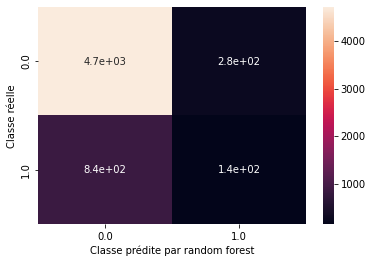

In [ ]:
# On reprend notre modèle KNN
knn = KNeighborsClassifier() #algorithm='auto', metric='minkowski', n_neighbors= 55, weights= 'uniform' ===== 0.88
cv = KFold(n_splits=3, random_state=22 , shuffle = True)

scores = cross_validate(knn, X_train, y_train, cv=cv, scoring=['accuracy','f1_micro', 'f1_macro', 'f1_weighted'])
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_knn, rownames = ['Classe réelle'], colnames = ['Classe prédite par random forest'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_knn));
print(classification_report_imbalanced(y_test, y_pred_knn)) 

* Tambien tomamos los pronosticos sobre el partido de entrenamiento

Accuracy:  0.8501148465232825


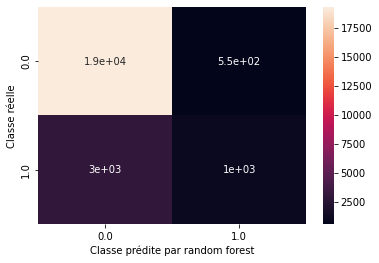

In [ ]:
# On prend aussi les prédictions sur le jeu d'entraînement
y_pred_knn_train = knn.predict(X_train)
confusion_matrix=pd.crosstab(y_train, y_pred_knn_train, rownames = ['Classe réelle'], colnames = ['Classe prédite par random forest'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_train, y_pred_knn_train));

* Obtenemos nuestras predicciones en el dataframe

In [ ]:
# On récupère nos prédictions dans un dataframe
y_pred_knn_df= pd.DataFrame(y_pred_knn)
y_pred_knn_train_df = pd.DataFrame(y_pred_knn_train)

y = pd.concat([y_pred_knn_train_df, y_pred_knn_df])
y.columns = ['Prediction']
y.reset_index(inplace=True,drop=True)

In [ ]:
# On récupère nos données de départ
df_complet = df.copy()
df_complet.reset_index(inplace=True,drop=True)
# Ajout des prédictions faites à partir du KNN
df_avec_pred = pd.concat([df_complet, y],axis=1)
df_avec_pred.tail(20)

,case_id,Target90Days,OriginalCapitalOfCaseInvoices,IndustryCode,ClientName,NumberOfUnsuccessfullyClosedCustomerCasesLast36Months,AmountOfCustomerPaymentsOnAllCasesBlevel,AmountOfCustomerOpenCases,NumberOfTelephonesCI,AgeOfDebt,NumberOfCustomerIncomingCallDatesTee,CustomerAge,NumberOfCustomerPaymentsInLast12Months,LastOriginalClosingCodeOfCustomer,AmountOfCase,Prediction
29912,29981.0,1.0,237.74,7,22.0,0.0,86.05,499.37,3.0,12.0,1.0,46.0,5.0,4.0,287.74,0.0
29913,29982.0,0.0,41.80,5,2.0,0.0,43.99,0.00,3.0,103.0,0.0,43.0,1.0,6.0,102.80,0.0
29914,29983.0,0.0,613.00,5,11.0,0.0,66.97,0.00,1.0,62.0,0.0,39.0,0.0,7.0,628.00,0.0
29915,29984.0,0.0,991.52,5,6.0,1.0,0.00,0.00,3.0,4.0,0.0,33.0,0.0,1.0,1079.52,0.0
29916,29985.0,1.0,10500.00,5,181.0,0.0,0.00,75.43,1.0,531.0,0.0,27.0,0.0,4.0,10500.00,0.0
29917,29986.0,1.0,851.52,5,67.0,1.0,634.05,0.00,4.0,523.0,5.0,36.0,5.0,7.0,851.52,0.0
29918,29987.0,0.0,151.51,5,2.0,0.0,0.00,322.11,1.0,108.0,0.0,42.0,0.0,4.0,212.88,0.0
29919,29988.0,0.0,338.27,7,55.0,1.0,0.00,0.00,2.0,62.0,0.0,29.0,0.0,1.0,338.27,1.0
29920,29989.0,0.0,221.09,5,10.0,0.0,0.00,0.00,3.0,129.0,0.0,60.0,0.0,1.0,241.56,0.0
29921,29990.0,0.0,456.47,5,11.0,0.0,0.00,0.00,5.0,65.0,0.0,30.0,0.0,38.0,471.47,0.0


# Interpretacion

* Etude de l'importance des variables conservées avec un modèle Lasso

In [ ]:
# On reprend notre modèle KNN
knn = KNeighborsClassifier()
cv = KFold(n_splits=3, random_state=22 , shuffle = True)

scores = cross_validate(knn, X_train, y_train, cv=cv, scoring=['accuracy','f1_micro', 'f1_macro', 'f1_weighted'])
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_knn, rownames = ['Classe réelle'], colnames = ['Classe prédite par random forest'])

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_knn));

In [ ]:
#@title
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
coef = pd.Series(reg.coef_, index = X_train)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [ ]:
#@title
fig = plt.figure(figsize=(6,6))
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importance des variables en utilisation un modèle Lasso");

In [ ]:
pip install shap

In [ ]:
import shap

X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

# Création des valeurs SHAP
knn_explainer = shap.KernelExplainer(knn.predict,X_test)
knn_shap_values = knn_explainer.shap_values(X_test)
shap.summary_plot(knn_shap_values, X_test)